In [177]:
from math import sqrt
from datetime import timedelta, datetime

import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, _customer_lifetime_value
from lifetimes.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [181]:
df = pd.read_csv("../data/ltv_cleaned_data.csv", index_col=0)

df[["event_timestamp", "first_purchase_time", "cohort_week"]] = df[
    ["event_timestamp", "first_purchase_time", "cohort_week"]
].apply(pd.to_datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1200 non-null   object        
 1   event_timestamp      1200 non-null   datetime64[ns]
 2   first_purchase_time  1200 non-null   datetime64[ns]
 3   cohort_week          1200 non-null   datetime64[ns]
 4   product_id           1200 non-null   object        
 5   lifetime_months      1200 non-null   int64         
 6   price                1200 non-null   float64       
 7   frequency            1200 non-null   int64         
 8   revenue              1200 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int64(2), object(2)
memory usage: 93.8+ KB


# Prepare prediction dataframe

In [182]:
df.describe()

,event_timestamp,first_purchase_time,cohort_week,lifetime_months,price,frequency,revenue
count,1200,1200,1200,1200.000000,1.200000e+03,1200.000000,1200.000000
mean,2023-05-16 22:08:55.034166528,2023-04-03 23:56:55.034166784,2023-03-30 10:40:48,1.430833,1.249000e+01,3.773333,47.128933
min,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,0.000000,1.249000e+01,1.000000,12.490000
25%,2023-04-05 11:13:16.500000,2023-03-17 08:11:44,2023-03-12 00:00:00,0.000000,1.249000e+01,1.000000,12.490000
50%,2023-05-02 05:23:36.500000,2023-03-31 09:34:10.500000,2023-03-26 00:00:00,1.000000,1.249000e+01,4.000000,49.960000
75%,2023-06-18 15:04:00.249999872,2023-04-22 06:10:08,2023-04-16 00:00:00,2.000000,1.249000e+01,6.000000,74.940000
max,2023-10-14 06:00:06,2023-05-07 14:00:39,2023-04-30 00:00:00,7.000000,1.249000e+01,8.000000,99.920000
std,NaN,NaN,NaN,1.787329,3.554195e-15,2.411805,30.123443


In [183]:
# find_outliers = df["lifetime_months"] < 6
# df = df[find_outliers]
# RMSE:  6.131058669503068 mae:  3.4775814510101237

prediction_df = df.drop(columns=["price", "frequency", "lifetime_months"])

prediction_df.describe()

,event_timestamp,first_purchase_time,cohort_week,revenue
count,1200,1200,1200,1200.000000
mean,2023-05-16 22:08:55.034166528,2023-04-03 23:56:55.034166784,2023-03-30 10:40:48,47.128933
min,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000
25%,2023-04-05 11:13:16.500000,2023-03-17 08:11:44,2023-03-12 00:00:00,12.490000
50%,2023-05-02 05:23:36.500000,2023-03-31 09:34:10.500000,2023-03-26 00:00:00,49.960000
75%,2023-06-18 15:04:00.249999872,2023-04-22 06:10:08,2023-04-16 00:00:00,74.940000
max,2023-10-14 06:00:06,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000
std,NaN,NaN,NaN,30.123443


In [184]:
observation_period_end = str(prediction_df["event_timestamp"].max().date())

observation_period_end

'2023-10-14'

In [186]:
summary_df = summary_data_from_transaction_data(
    prediction_df,
    "user_id",
    "event_timestamp",
    observation_period_end=observation_period_end,
)
summary_df = summary_df.merge(prediction_df, on="user_id")

summary_df.head()

,user_id,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,product_id,revenue
0,0047993c-3cff-4ab4-a34a-e376f823c282,0.0,0.0,206.0,2023-03-22 06:02:55,2023-03-22 06:02:55,2023-03-19,monthly.12.49,12.49
1,00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,0.0,0.0,180.0,2023-04-17 10:19:29,2023-04-17 10:19:29,2023-04-16,monthly.12.49,12.49
2,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-04-16 15:14:30,2023-04-16 15:14:30,2023-04-09,monthly.12.49,24.98
3,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-05-16 15:14:30,2023-04-16 15:14:30,2023-04-09,monthly.12.49,24.98
4,0126e40c-da09-4e28-b687-457716e6ccfd,0.0,0.0,219.0,2023-03-09 16:54:50,2023-03-09 16:54:50,2023-03-05,monthly.12.49,12.49


In [164]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_df["frequency"], summary_df["recency"], summary_df["T"])

<lifetimes.BetaGeoFitter: fitted with 1155 subjects, a: 0.00, alpha: 93.73, b: 0.01, r: 1.27>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

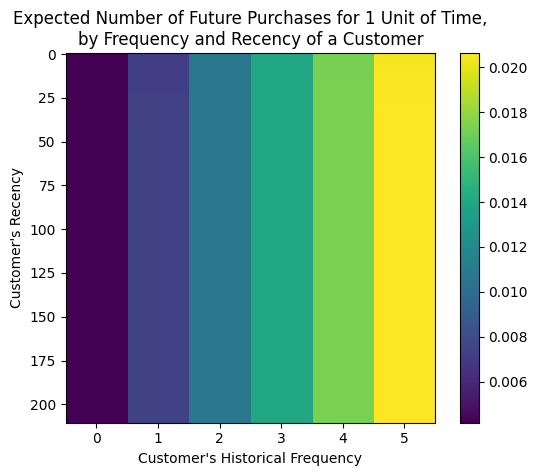

In [165]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

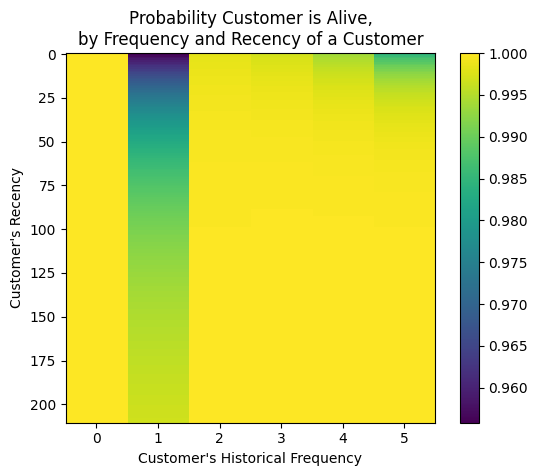

In [166]:
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

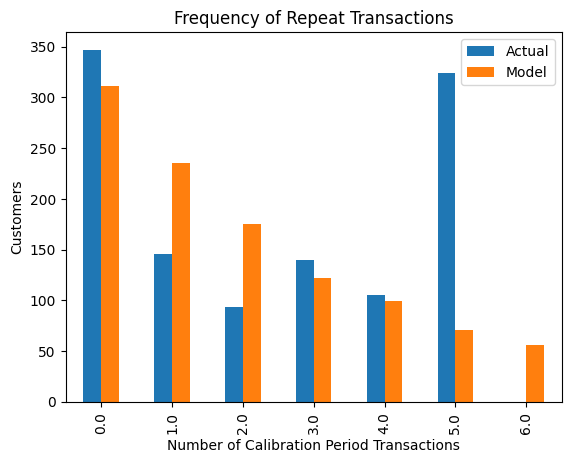

In [167]:
plot_period_transactions(bgf)

In [168]:
_customer_lifetime_value(
    bgf,
    summary_df["frequency"],
    summary_df["recency"],
    summary_df["T"],
    summary_df["revenue"],
    time=12,
    freq="M",
).to_frame().rename(columns={"clv": "ltv"})

,ltv
0,0.618678
1,0.680128
2,2.383142
3,2.383142
4,0.591936
...,...
1150,21.064765
1151,21.064765
1152,21.064765
1153,21.064765


In [169]:
summary_df["prediction_period"] = summary_df["event_timestamp"].min() + timedelta(
    days=365
)

summary_df["rest"] = (
    summary_df["prediction_period"] - summary_df["event_timestamp"]
).dt.days / 30.44

summary_df.describe()

,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,revenue,prediction_period,rest
count,1155.000000,1155.000000,1155.000000,1155,1155,1155,1155.000000,1155,1155.000000
mean,2.417316,74.935065,181.012987,2023-05-11 20:01:23.057142784,2023-04-04 10:59:02.797402624,2023-03-30 21:22:54.545454592,45.493879,2024-03-05 04:55:29.999999744,9.781843
min,0.000000,0.000000,148.000000,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000,2024-03-05 04:55:30,5.059133
25%,0.000000,0.000000,163.000000,2023-04-02 16:06:03,2023-03-17 11:21:29.500000,2023-03-12 00:00:00,12.490000,2024-03-05 04:55:30,8.837057
50%,2.000000,90.000000,185.000000,2023-04-30 06:12:02,2023-03-31 15:20:06,2023-03-26 00:00:00,37.470000,2024-03-05 04:55:30,10.151117
75%,5.000000,150.000000,199.000000,2023-06-09 12:13:16,2023-04-22 13:13:27,2023-04-16 00:00:00,74.940000,2024-03-05 04:55:30,11.070959
max,5.000000,150.000000,210.000000,2023-10-02 11:54:27,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000,2024-03-05 04:55:30,11.990802
std,2.041352,62.062124,19.691705,NaN,NaN,NaN,29.407534,NaN,1.635680


In [170]:
def equity(row):
    rest = row["rest"].values[0]
    return _customer_lifetime_value(
        bgf,
        summary_df["frequency"],
        summary_df["recency"],
        summary_df["T"],
        summary_df["revenue"],  # monetary_value
        time=12,
        discount_rate=0.1,
        freq="M",
    )


def e_purchases(row, bgf):
    return bgf.conditional_expected_number_of_purchases_up_to_time(
        row["rest"],  # period for which customer that we want to predict future value
        row["frequency"],
        row["recency"],
        row["T"],
    )


summary_df["equity"] = 0
for i, row in summary_df.iterrows():
    summary_df.at[i, "equity"] = equity(row.to_frame().T).values[0]

In [171]:
summary_df["ltv"] = summary_df["revenue"] + summary_df["equity"]
summary_df["purchases"] = summary_df.apply(
    lambda row: e_purchases(row, bgf) + row["frequency"] + 1, axis=1
)

summary_df.describe()

,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,revenue,prediction_period,rest,equity,ltv,purchases
count,1155.000000,1155.000000,1155.000000,1155,1155,1155,1155.000000,1155,1155.000000,1155.000000,1155.000000,1155.000000
mean,2.417316,74.935065,181.012987,2023-05-11 20:01:23.057142784,2023-04-04 10:59:02.797402624,2023-03-30 21:22:54.545454592,45.493879,2024-03-05 04:55:29.999999744,9.781843,0.374549,45.868428,3.540959
min,0.000000,0.000000,148.000000,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000,2024-03-05 04:55:30,5.059133,0.374549,12.864549,1.049855
25%,0.000000,0.000000,163.000000,2023-04-02 16:06:03,2023-03-17 11:21:29.500000,2023-03-12 00:00:00,12.490000,2024-03-05 04:55:30,8.837057,0.374549,12.864549,1.051600
50%,2.000000,90.000000,185.000000,2023-04-30 06:12:02,2023-03-31 15:20:06,2023-03-26 00:00:00,37.470000,2024-03-05 04:55:30,10.151117,0.374549,37.844549,3.132993
75%,5.000000,150.000000,199.000000,2023-06-09 12:13:16,2023-04-22 13:13:27,2023-04-16 00:00:00,74.940000,2024-03-05 04:55:30,11.070959,0.374549,75.314549,6.141796
max,5.000000,150.000000,210.000000,2023-10-02 11:54:27,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000,2024-03-05 04:55:30,11.990802,0.374549,100.294549,6.256986
std,2.041352,62.062124,19.691705,NaN,NaN,NaN,29.407534,NaN,1.635680,0.000000,29.407534,2.100587


In [172]:
# The last five values indicates 5 users who are most likely to make a purchase and in what period

In [173]:
summary_df.sort_values(by="purchases").tail(5)

,user_id,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,product_id,revenue,prediction_period,rest,equity,ltv,purchases
1011,e13dd319-b93b-49d4-802f-f49247d5af40,5.0,150.0,153.0,2023-05-02 17:37:49,2023-05-02 17:37:49,2023-04-30,monthly.12.49,74.94,2024-03-05 04:55:30,10.085414,0.374549,75.314549,6.256151
123,1a2ba92a-c4f6-463c-8bfc-131ed09f62d9,5.0,150.0,157.0,2023-04-28 02:29:45,2023-04-28 02:29:45,2023-04-23,monthly.12.49,74.94,2024-03-05 04:55:30,10.249671,0.374549,75.314549,6.256170
132,1b3c596e-2f1c-47f5-a132-7d6913a36ad1,5.0,150.0,150.0,2023-05-05 11:54:27,2023-05-05 11:54:27,2023-04-30,monthly.12.49,74.94,2024-03-05 04:55:30,9.986859,0.374549,75.314549,6.256771
354,551a4e12-6915-4e51-a438-fdc879cb9065,5.0,150.0,150.0,2023-05-05 09:49:05,2023-05-05 09:49:05,2023-04-30,monthly.12.49,74.94,2024-03-05 04:55:30,9.986859,0.374549,75.314549,6.256771
1126,f91e66c8-bf50-43f8-b096-d70067b66e40,5.0,150.0,153.0,2023-05-02 04:09:37,2023-05-02 04:09:37,2023-04-30,monthly.12.49,74.94,2024-03-05 04:55:30,10.118265,0.374549,75.314549,6.256986


# ANALYSE THIS SUMMARY

In [174]:
summary_df.groupby("frequency").agg(
    ltv_avg=("ltv", "mean"),
    equity_avg=("equity", "mean"),
    revenue_avg=("revenue", "mean"),
    purchases_avg=("purchases", "mean"),
)

,ltv_avg,equity_avg,revenue_avg,purchases_avg
frequency,,,,
0.0,12.864549,0.374549,12.490000,1.050795
1.0,25.696741,0.374549,25.322192,2.084012
2.0,37.844549,0.374549,37.470000,3.118647
3.0,50.334549,0.374549,49.960000,4.147178
4.0,64.014073,0.374549,63.639524,5.172311
5.0,84.797697,0.374549,84.423148,6.195012


In [175]:
summary_df["predicted_revenue"] = summary_df["purchases"] * price

summary_df.describe()

,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,revenue,prediction_period,rest,equity,ltv,purchases,predicted_revenue
count,1155.000000,1155.000000,1155.000000,1155,1155,1155,1155.000000,1155,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000
mean,2.417316,74.935065,181.012987,2023-05-11 20:01:23.057142784,2023-04-04 10:59:02.797402624,2023-03-30 21:22:54.545454592,45.493879,2024-03-05 04:55:29.999999744,9.781843,0.374549,45.868428,3.540959,44.226577
min,0.000000,0.000000,148.000000,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000,2024-03-05 04:55:30,5.059133,0.374549,12.864549,1.049855,13.112690
25%,0.000000,0.000000,163.000000,2023-04-02 16:06:03,2023-03-17 11:21:29.500000,2023-03-12 00:00:00,12.490000,2024-03-05 04:55:30,8.837057,0.374549,12.864549,1.051600,13.134483
50%,2.000000,90.000000,185.000000,2023-04-30 06:12:02,2023-03-31 15:20:06,2023-03-26 00:00:00,37.470000,2024-03-05 04:55:30,10.151117,0.374549,37.844549,3.132993,39.131082
75%,5.000000,150.000000,199.000000,2023-06-09 12:13:16,2023-04-22 13:13:27,2023-04-16 00:00:00,74.940000,2024-03-05 04:55:30,11.070959,0.374549,75.314549,6.141796,76.711033
max,5.000000,150.000000,210.000000,2023-10-02 11:54:27,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000,2024-03-05 04:55:30,11.990802,0.374549,100.294549,6.256986,78.149751
std,2.041352,62.062124,19.691705,NaN,NaN,NaN,29.407534,NaN,1.635680,0.000000,29.407534,2.100587,26.236331


In [178]:
y_actual = summary_df["revenue"]
y_predicted = summary_df["predicted_revenue"]

MSE = mean_squared_error(y_actual, y_predicted)
RMSE = sqrt(MSE)

MAE = mean_absolute_error(y_actual, y_predicted)

print("RMSE: ", RMSE, "mae: ", MAE)

RMSE:  6.131058669503068 mae:  3.4775814510101237


# SAVE MODEL bgf_ltv_prediction_full_data.pkl

In [146]:
bgf.save_model("../models/bgf_ltv_prediction_full_data.pkl")